<hr style="border:2px solid #C2D500"> </hr>
<a><img src="https://cdn.forbes.com.mx/2018/11/mercado_libre.jpg1_-640x360.jpg" width="300" align="center"></a>
<hr style="border:2px solid #C2D500"> </hr>
<h1><center>Data scientist technical challenge</center></h1>
<h1><center>2 de Noviembre de 2021</center></h1>

<a name="intro"></a><hr style="border:1px solid #15B9B1"> </hr>
# Introducción
<hr style="border:1px solid #15B9B1"> </hr>

Los pagos realizados a través de Mercadopago han crecido exponencialmente mes a mes los últimos años, al punto tal de que hoy en día el volumen de transacciones realizadas por fuera del marketplace superan a las realizadas internamente.

Parte de este crecimiento está en la prevención de fraude en los distintos productos de MercadoPago. Esto es vital para garantizar una excelente experiencia para los usuarios y reducir las pérdidas económicas por fraudes.

El fraude en plataformas de pagos, es una problemática mundial que representa pérdidas económicas a gran escala. MercadoPago, por su dimensión y presencia regional, es blanco de este tipo de ataques diariamente. Construir modelos de machine learning para prevención de fraude robustos y escalables que analicen todo el ﬂujo de pagos es indispensable para la seguridad de nuestros usuarios.

In [1]:
!pip install xgboost
!pip install imbalanced-learn

<a name="lib"></a><hr style="border:1px solid #15B9B1"> </hr>
# Librerías y Funciones
<hr style="border:1px solid #15B9B1"> </hr>

In [2]:
import warnings
warnings.filterwarnings("ignore")
import joblib
import pickle
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

import machinelearning_classification as mlc


<a name="lib"></a><hr style="border:1px solid #15B9B1"> </hr>
# Parámetros generales para el usuario
<hr style="border:1px solid #15B9B1"> </hr>

Los parámetros que se presentan aca son un conjunto de opciones que el evaluador podrá modificar con el fin de tener diferentes opciones en la ejecución y evaluación del desarrollo.

Los posibles valores de cada parametro se encontran comentados en cada uno de estos.

In [3]:
cleaning = 2 # parametro que permitirá seleccionar si se desean eliminar todos los registros con datos faltantes (1),
             # si primero se elimina la caracteristica K dado que es la que presenta mayor cantidad de vacios 
             # y posteriormente se eliminan los registros con nan (2) y finalmente 
             # se realiza una imputacion de datos de datos faltantes con la mediana de cada caracteristica (3).
        
resampling = 1 # determinar si se desea o no usar una tecnica para eliminar algunas muestras de la clase mayoritaria (1) y 
               # y si se desea evaluar los modelos con el desbalanceo original utilizar (0)
    

<a name="lib"></a><hr style="border:1px solid #15B9B1"> </hr>
# Carga de la información
<hr style="border:1px solid #15B9B1"> </hr>

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/juanmvm1331/challenge_MELI/main/data.csv")
data.sample(10)

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,Monto,Fraude
14263,0,2,5.0,0,0,0.000,0.0,0,0,BR,...,1,1,1,0,1,0.00,0.00,12.10,25.94,0
8578,0,1,3725.0,0,0,0.000,0.0,0,0,AR,...,1,1,1,0,1,0.00,0.00,6.86,196.47,0
12428,0,4,646.0,0,0,0.000,0.0,0,0,MX,...,0,2,1,0,2,0.00,0.00,50.79,106.48,0
13232,0,10,25609.0,0,0,0.000,0.0,0,0,BR,...,0,4,1,0,1,0.00,0.00,30.42,26.58,0
11407,0,9,2680.0,0,0,0.000,0.0,0,0,MX,...,0,1,1,0,1,0.00,0.00,17.03,106.98,0
3967,0,5,13014.0,0,0,0.000,0.0,0,0,AR,...,0,3,1,0,1,0.00,0.00,15.48,66.26,0
5486,0,12,1405.0,0,0,0.000,0.0,0,0,AR,...,0,1,1,0,1,0.00,0.00,32.87,143.08,0
2859,0,3,36626.0,0,0,0.000,0.0,0,0,AR,...,2,3,3,0,1,91.45,0.00,22.71,52.48,1
6976,0,6,66.0,0,1,0.125,0.0,0,1,AR,...,0,1,1,0,1,0.00,0.00,27.00,22.16,0
306,1,6,17151.0,0,0,0.000,0.0,0,0,US,...,1,1,1,0,1,0.00,0.00,36.78,312.53,1


<a name="lib"></a><hr style="border:1px solid #15B9B1"> </hr>
# Analisis y transformación inicial de los datos.
<hr style="border:1px solid #15B9B1"> </hr>

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       16880 non-null  int64  
 1   B       16880 non-null  int64  
 2   C       13683 non-null  float64
 3   D       16880 non-null  int64  
 4   E       16880 non-null  int64  
 5   F       16880 non-null  float64
 6   G       16880 non-null  float64
 7   H       16880 non-null  int64  
 8   I       16880 non-null  int64  
 9   J       16880 non-null  object 
 10  K       4016 non-null   float64
 11  L       16880 non-null  int64  
 12  M       16880 non-null  int64  
 13  N       16880 non-null  int64  
 14  O       16880 non-null  int64  
 15  P       16880 non-null  int64  
 16  Q       16880 non-null  object 
 17  R       16880 non-null  object 
 18  S       16880 non-null  float64
 19  Monto   16880 non-null  object 
 20  Fraude  16880 non-null  int64  
dtypes: float64(5), int64(12), object(4)

In [6]:
# casteo de variables
data['Q'] = pd.to_numeric([list(data['Q'])[i].replace(',','') for i in range(len(list(data['Q'])))])
data['R'] = pd.to_numeric([list(data['R'])[i].replace(',','') for i in range(len(list(data['R'])))])
data['Monto'] = pd.to_numeric([list(data['Monto'])[i].replace(',','') for i in range(len(list(data['Monto'])))])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       16880 non-null  int64  
 1   B       16880 non-null  int64  
 2   C       13683 non-null  float64
 3   D       16880 non-null  int64  
 4   E       16880 non-null  int64  
 5   F       16880 non-null  float64
 6   G       16880 non-null  float64
 7   H       16880 non-null  int64  
 8   I       16880 non-null  int64  
 9   J       16880 non-null  object 
 10  K       4016 non-null   float64
 11  L       16880 non-null  int64  
 12  M       16880 non-null  int64  
 13  N       16880 non-null  int64  
 14  O       16880 non-null  int64  
 15  P       16880 non-null  int64  
 16  Q       16880 non-null  float64
 17  R       16880 non-null  float64
 18  S       16880 non-null  float64
 19  Monto   16880 non-null  float64
 20  Fraude  16880 non-null  int64  
dtypes: float64(8), int64(12), object(1)

In [7]:
data_missing = data.copy()
for col in data_missing.columns:
    pct_missing = np.mean(data_missing[col].isnull())
    print('Porcentaje de datos perdidos para {} - {}%'.format(col, round(pct_missing*100)))

Porcentaje de datos perdidos para A - 0%
Porcentaje de datos perdidos para B - 0%
Porcentaje de datos perdidos para C - 19%
Porcentaje de datos perdidos para D - 0%
Porcentaje de datos perdidos para E - 0%
Porcentaje de datos perdidos para F - 0%
Porcentaje de datos perdidos para G - 0%
Porcentaje de datos perdidos para H - 0%
Porcentaje de datos perdidos para I - 0%
Porcentaje de datos perdidos para J - 0%
Porcentaje de datos perdidos para K - 76%
Porcentaje de datos perdidos para L - 0%
Porcentaje de datos perdidos para M - 0%
Porcentaje de datos perdidos para N - 0%
Porcentaje de datos perdidos para O - 0%
Porcentaje de datos perdidos para P - 0%
Porcentaje de datos perdidos para Q - 0%
Porcentaje de datos perdidos para R - 0%
Porcentaje de datos perdidos para S - 0%
Porcentaje de datos perdidos para Monto - 0%
Porcentaje de datos perdidos para Fraude - 0%


In [8]:
for col in data_missing.columns:
    unique_values = len(data_missing[col].unique())
    print('Cantidad de valores únicos para {} - {}'.format(col, unique_values))

Cantidad de valores únicos para A - 21
Cantidad de valores únicos para B - 21
Cantidad de valores únicos para C - 9783
Cantidad de valores únicos para D - 31
Cantidad de valores únicos para E - 23
Cantidad de valores únicos para F - 153
Cantidad de valores únicos para G - 106
Cantidad de valores únicos para H - 14
Cantidad de valores únicos para I - 17
Cantidad de valores únicos para J - 19
Cantidad de valores únicos para K - 87
Cantidad de valores únicos para L - 8
Cantidad de valores únicos para M - 11
Cantidad de valores únicos para N - 10
Cantidad de valores únicos para O - 4
Cantidad de valores únicos para P - 14
Cantidad de valores únicos para Q - 605
Cantidad de valores únicos para R - 109
Cantidad de valores únicos para S - 6467
Cantidad de valores únicos para Monto - 9616
Cantidad de valores únicos para Fraude - 2


In [9]:
data.describe()

,A,B,C,D,E,F,G,H,I,K,L,M,N,O,P,Q,R,S,Monto,Fraude
count,16880.000000,16880.000000,13683.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,4016.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000
mean,0.309242,7.645379,39235.339984,0.198697,0.433709,0.015878,0.005200,0.050296,0.144076,0.682099,0.432346,1.544135,1.091765,0.009419,1.630865,8.445394,1.994921,29.127720,161.837033,0.273164
std,1.094064,4.686494,91045.252879,2.042959,1.537297,0.098730,0.059419,0.531060,0.824761,0.153264,0.663860,1.022385,0.408081,0.116606,1.088286,74.367729,38.222485,26.510548,275.499961,0.445597
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,0.050000,0.000000
25%,0.000000,4.000000,1172.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,9.560000,33.807500,0.000000
50%,0.000000,7.000000,6173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.680000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,20.640000,81.645000,0.000000
75%,0.000000,11.000000,26888.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,1.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000,39.212500,193.440000,1.000000
max,30.000000,20.000000,617324.000000,180.000000,45.000000,1.000000,1.000000,21.000000,24.000000,0.990000,7.000000,13.000000,10.000000,3.000000,41.000000,2274.670000,2025.720000,99.970000,12538.440000,1.000000


In [10]:
print('El porcentaje para la clase de fraudes es de {} %'.format((data.Fraude.sum()*100)/len(data)))
print('El porcentaje para la clase de No fraudes es de {} %'.format(100-(data.Fraude.sum()*100)/len(data)))

El porcentaje para la clase de fraudes es de 27.316350710900473 %
El porcentaje para la clase de No fraudes es de 72.68364928909952 %


In [11]:
data.groupby('J')['Fraude'].sum()

J
AR    2626
AU       0
BR    1099
CA       0
CH       0
CL       0
CO       0
ES     295
FR       0
GB       0
GT       0
IT       0
KR       0
MX     216
PT       0
TR       0
UA       0
US     195
UY     180
Name: Fraude, dtype: int64

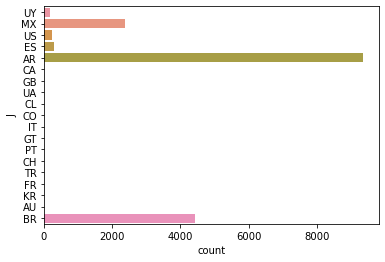

In [12]:
for col in data.select_dtypes(include='object'):
    sns.countplot(y=col, data=data)

<a name="lib"></a><hr style="border:1px solid #15B9B1"> </hr>
# Limpieza de datos y reevaluación del porcentaje de balanceo.
<hr style="border:1px solid #15B9B1"> </hr>

In [13]:
data_clean = data.copy()
if cleaning==1:
    data_clean = data_clean.dropna().reset_index(drop=True)
elif cleaning==2:
    data_clean = data_clean.drop(['K'], axis=1)
    data_clean = data_clean.dropna().reset_index(drop=True)
else:
    data_clean = data.fillna(data.median())
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13683 entries, 0 to 13682
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       13683 non-null  int64  
 1   B       13683 non-null  int64  
 2   C       13683 non-null  float64
 3   D       13683 non-null  int64  
 4   E       13683 non-null  int64  
 5   F       13683 non-null  float64
 6   G       13683 non-null  float64
 7   H       13683 non-null  int64  
 8   I       13683 non-null  int64  
 9   J       13683 non-null  object 
 10  L       13683 non-null  int64  
 11  M       13683 non-null  int64  
 12  N       13683 non-null  int64  
 13  O       13683 non-null  int64  
 14  P       13683 non-null  int64  
 15  Q       13683 non-null  float64
 16  R       13683 non-null  float64
 17  S       13683 non-null  float64
 18  Monto   13683 non-null  float64
 19  Fraude  13683 non-null  int64  
dtypes: float64(7), int64(12), object(1)
memory usage: 2.1+ MB


In [14]:
print('El porcentaje para la clase de fraudes es de {} %'.format((data_clean.Fraude.sum()*100)/len(data)))
print('El porcentaje para la clase de No fraudes es de {} %'.format(100-(data_clean.Fraude.sum()*100)/len(data)))

El porcentaje para la clase de fraudes es de 24.040284360189574 %
El porcentaje para la clase de No fraudes es de 75.95971563981043 %


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>,
        <AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>],
       [<AxesSubplot:title={'center':'E'}>,
        <AxesSubplot:title={'center':'F'}>,
        <AxesSubplot:title={'center':'G'}>,
        <AxesSubplot:title={'center':'H'}>],
       [<AxesSubplot:title={'center':'I'}>,
        <AxesSubplot:title={'center':'L'}>,
        <AxesSubplot:title={'center':'M'}>,
        <AxesSubplot:title={'center':'N'}>],
       [<AxesSubplot:title={'center':'O'}>,
        <AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'Q'}>,
        <AxesSubplot:title={'center':'R'}>],
       [<AxesSubplot:title={'center':'S'}>,
        <AxesSubplot:title={'center':'Monto'}>,
        <AxesSubplot:title={'center':'Fraude'}>, <AxesSubplot:>]],
      dtype=object)

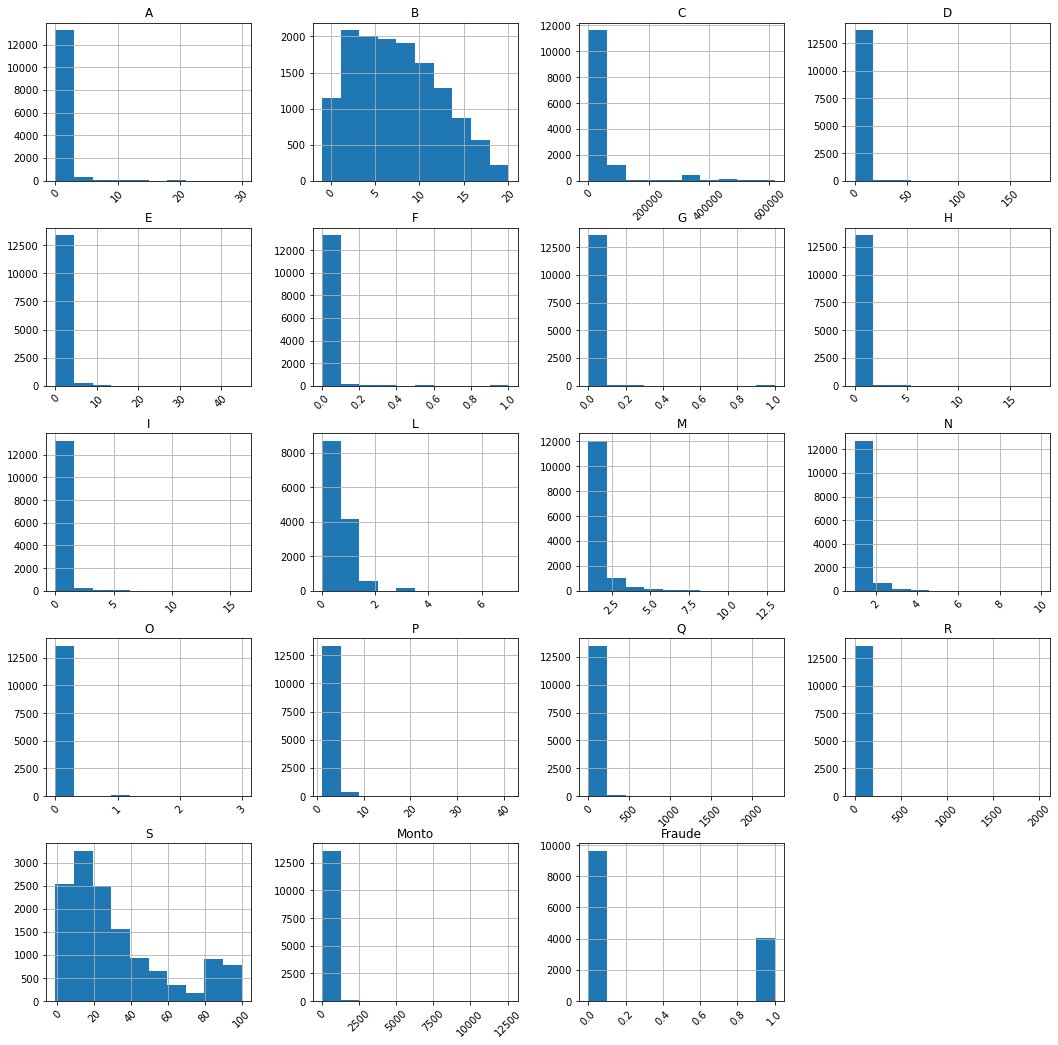

In [15]:
data_clean.hist(figsize=(18,18), xrot=45)

<AxesSubplot:>

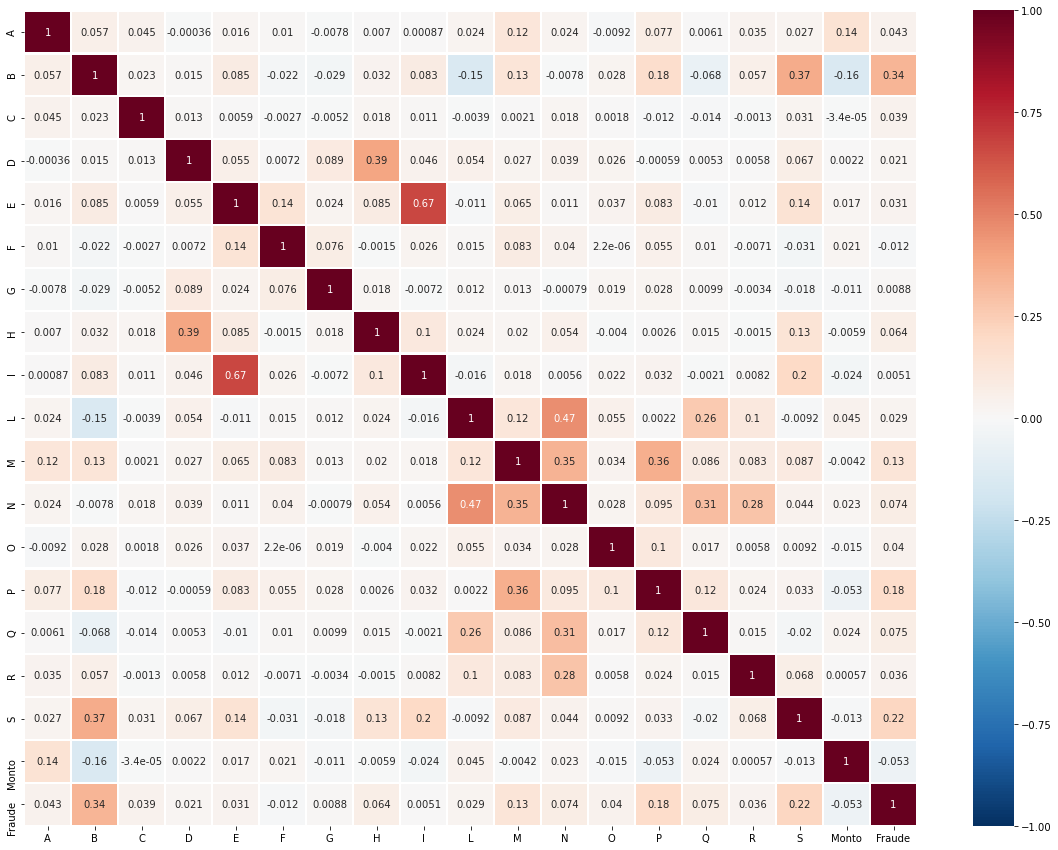

In [16]:
corr = data_clean.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr, cmap='RdBu_r', annot=True, vmax=1, vmin=-1, linewidths=1.5)

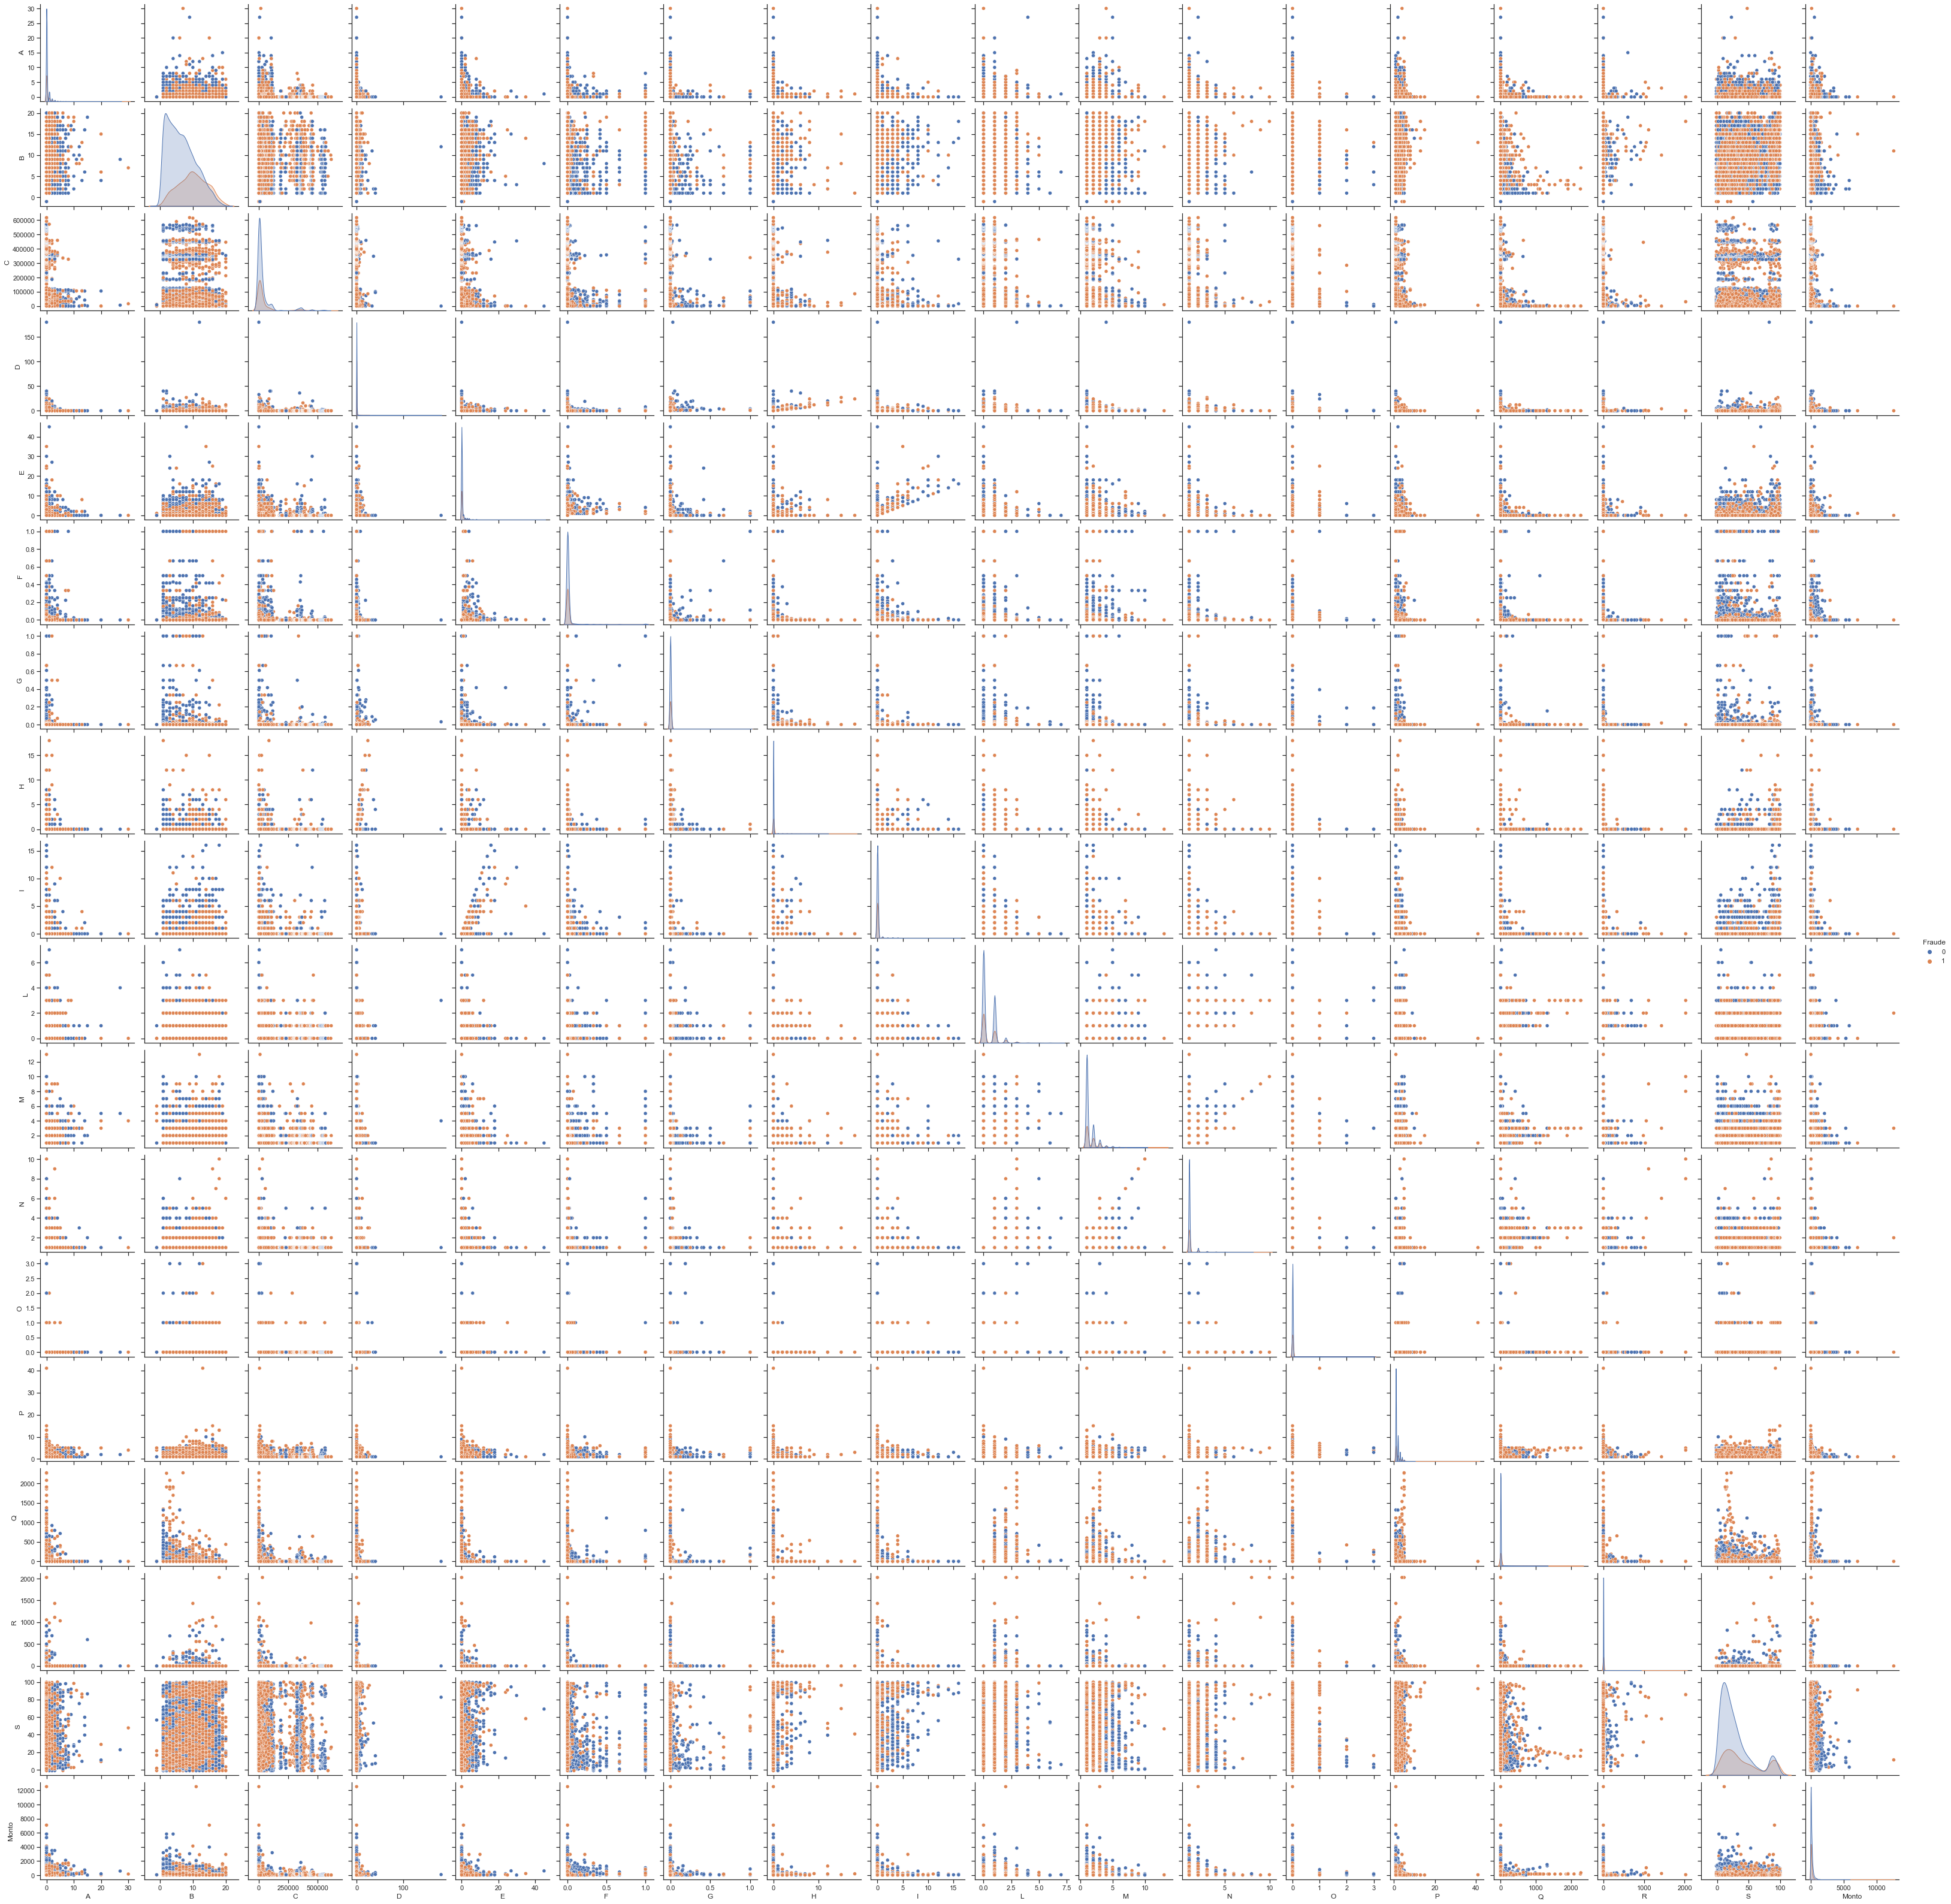

In [17]:
sns.set(style='ticks', color_codes=True)
sns.pairplot(data_clean, hue='Fraude')

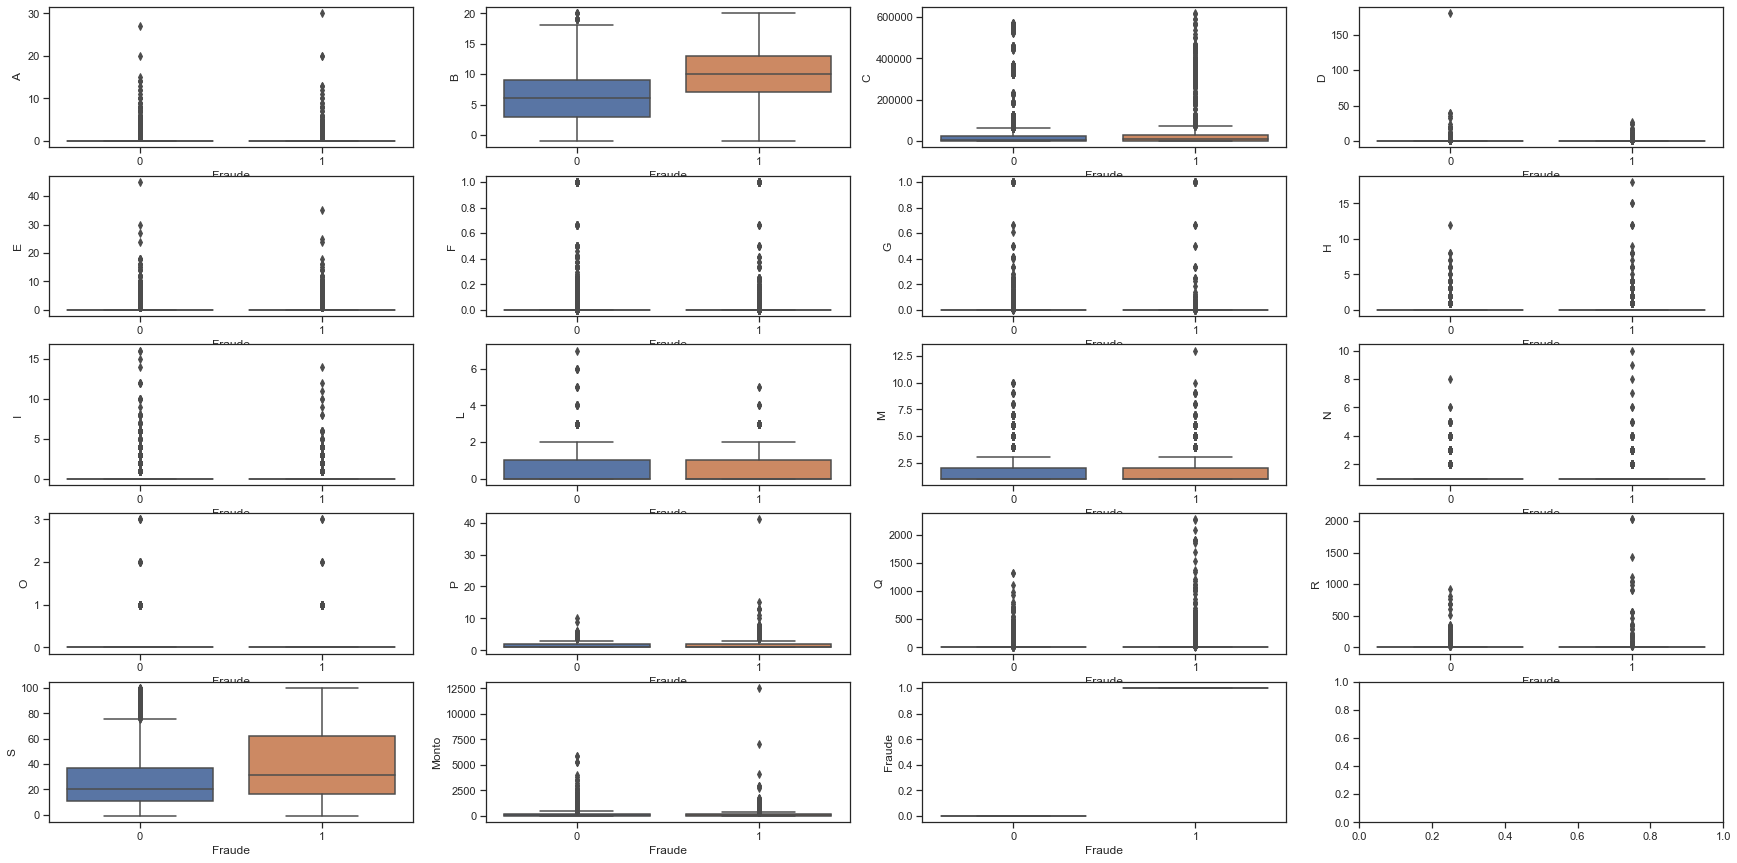

In [18]:
data_boxplot = data_clean.copy().drop(columns=['J'])
fig, axes = plt.subplots(5,4,figsize=(30,15))
for name, ax in zip(data_boxplot, axes.flatten()):
    sns.boxplot(y=name, x= "Fraude", data=data_boxplot, orient='v', ax=ax)

## Evaluación del PCA

In [19]:
data_pca = data_clean.copy().drop(columns=['J','Fraude'])
data_pca.info()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_pca)
print(np.shape(data_scaled))
pca = PCA(n_components=5)
pca.fit(data_scaled)
print(sum(pca.explained_variance_ratio_))
data_reduced = pca.transform(data_scaled)
print(np.shape(data_reduced))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13683 entries, 0 to 13682
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       13683 non-null  int64  
 1   B       13683 non-null  int64  
 2   C       13683 non-null  float64
 3   D       13683 non-null  int64  
 4   E       13683 non-null  int64  
 5   F       13683 non-null  float64
 6   G       13683 non-null  float64
 7   H       13683 non-null  int64  
 8   I       13683 non-null  int64  
 9   L       13683 non-null  int64  
 10  M       13683 non-null  int64  
 11  N       13683 non-null  int64  
 12  O       13683 non-null  int64  
 13  P       13683 non-null  int64  
 14  Q       13683 non-null  float64
 15  R       13683 non-null  float64
 16  S       13683 non-null  float64
 17  Monto   13683 non-null  float64
dtypes: float64(7), int64(11)
memory usage: 1.9 MB
(13683, 18)
0.44274777465474396
(13683, 5)


<a name="lib"></a><hr style="border:1px solid #15B9B1"> </hr>
# Modelación Preliminar.
<hr style="border:1px solid #15B9B1"> </hr>

In [20]:
start = time.time()
num_folds = 5
kfold = KFold(n_splits=num_folds,shuffle=True,random_state=1)
visualizar_avance_grid = 10
paralelismo = -1 
repeticiones = 5
modelos = ['LinearDiscriminantAnalysis','LogisticRegression','KNN','DecisionTree',
            'AdaBoost','GradientBoosting','SVM','RandomForest','MLP','XGBoost']


In [21]:
x = np.array(data_clean.drop(columns=['J','Fraude','A','C','D','E','F','G','H','I','N','O','P','Q','R','L','M','Monto']))
y = np.array(data_clean['Fraude'])
xn = mlc.normalizar(x,np.max(x,0),np.min(x,0))
if resampling==1:
    cnn = RandomUnderSampler(random_state=0) 
    xn, y = cnn.fit_resample(xn, y)
print(np.shape(xn))
print('El porcentaje para la clase de fraudes es de {} %'.format((y.sum()*100)/len(y)))
print('El porcentaje para la clase de No fraudes es de {} %'.format(100-(y.sum()*100)/len(y)))

(8116, 2)
El porcentaje para la clase de fraudes es de 50.0 %
El porcentaje para la clase de No fraudes es de 50.0 %


In [22]:
resultados = mlc.creacion_modelos(modelos,repeticiones,kfold,xn,y,paralelismo)
end = time.time()
print('el tiempo transcurrido en esta ejecucion fue de {} segundos o de {} minutos'.format((end-start),(end-start)/60))

el tiempo transcurrido en esta ejecucion fue de 111.87964057922363 segundos o de 1.864660676320394 minutos


In [23]:
for i in resultados.keys():
    display(resultados[i])

,Accuracy LinearDiscriminantAnalysis,Precision LinearDiscriminantAnalysis,Recall LinearDiscriminantAnalysis,F1 LinearDiscriminantAnalysis,Area bajo la curva ROC LinearDiscriminantAnalysis,tiempo (s)LinearDiscriminantAnalysis
0,66.99,67.63,65.30,66.41,72.46,2.00
1,66.99,67.63,65.30,66.41,72.46,0.04
2,66.99,67.63,65.30,66.41,72.46,0.04
3,66.99,67.63,65.30,66.41,72.46,0.04
4,66.99,67.63,65.30,66.41,72.46,0.04


,Accuracy LogisticRegression,Precision LogisticRegression,Recall LogisticRegression,F1 LogisticRegression,Area bajo la curva ROC LogisticRegression,tiempo (s)LogisticRegression
0,67.08,67.56,65.82,66.65,72.47,0.05
1,67.08,67.56,65.82,66.65,72.47,0.05
2,67.08,67.56,65.82,66.65,72.47,0.05
3,67.08,67.56,65.82,66.65,72.47,0.05
4,67.08,67.56,65.82,66.65,72.47,0.05


,Accuracy KNN,Precision KNN,Recall KNN,F1 KNN,Area bajo la curva ROC KNN,tiempo (s)KNN
0,61.48,61.53,61.38,61.43,65.28,0.25
1,61.48,61.53,61.38,61.43,65.28,0.18
2,61.48,61.53,61.38,61.43,65.28,0.18
3,61.48,61.53,61.38,61.43,65.28,0.18
4,61.48,61.53,61.38,61.43,65.28,0.18


,Accuracy DecisionTree,Precision DecisionTree,Recall DecisionTree,F1 DecisionTree,Area bajo la curva ROC DecisionTree,tiempo (s)DecisionTree
0,58.10,58.28,57.87,57.99,57.97,0.12
1,58.14,58.16,57.84,57.80,57.96,0.09
2,58.14,58.06,57.69,57.95,58.12,0.09
3,58.00,58.31,57.74,57.98,57.95,0.08
4,58.01,58.22,57.74,57.91,58.06,0.09


,Accuracy AdaBoost,Precision AdaBoost,Recall AdaBoost,F1 AdaBoost,Area bajo la curva ROC AdaBoost,tiempo (s)AdaBoost
0,66.62,65.55,70.30,67.79,72.34,0.74
1,66.62,65.55,70.30,67.79,72.34,0.65
2,66.62,65.55,70.30,67.79,72.34,0.66
3,66.62,65.55,70.30,67.79,72.34,0.65
4,66.62,65.55,70.30,67.79,72.34,0.66


,Accuracy GradientBoosting,Precision GradientBoosting,Recall GradientBoosting,F1 GradientBoosting,Area bajo la curva ROC GradientBoosting,tiempo (s)GradientBoosting
0,66.74,65.75,69.93,67.76,72.60,1.46
1,66.74,65.75,69.93,67.76,72.61,1.46
2,66.74,65.75,69.93,67.76,72.61,1.47
3,66.74,65.75,69.93,67.76,72.61,1.49
4,66.74,65.75,69.93,67.76,72.60,1.48


,Accuracy SVM,Precision SVM,Recall SVM,F1 SVM,Area bajo la curva ROC SVM,tiempo (s)SVM
0,67.02,65.16,73.18,68.92,72.38,10.66
1,67.02,65.16,73.18,68.92,72.38,10.32
2,67.02,65.16,73.18,68.92,72.38,10.38
3,67.02,65.16,73.18,68.92,72.38,10.41
4,67.02,65.16,73.18,68.92,72.38,10.53


,Accuracy RandomForest,Precision RandomForest,Recall RandomForest,F1 RandomForest,Area bajo la curva ROC RandomForest,tiempo (s)RandomForest
0,58.08,57.97,57.66,57.93,63.41,2.60
1,57.87,58.07,58.05,57.88,63.55,2.59
2,57.75,58.01,58.01,58.05,63.52,2.58
3,57.95,57.97,57.67,57.91,63.48,2.59
4,57.93,57.82,57.91,58.01,63.46,2.58


,Accuracy MLP,Precision MLP,Recall MLP,F1 MLP,Area bajo la curva ROC MLP,tiempo (s)MLP
0,66.90,65.76,70.84,67.81,72.49,5.06
1,66.70,66.09,69.72,67.85,72.50,4.01
2,67.04,66.06,70.83,67.98,72.51,4.03
3,67.11,65.73,71.29,68.04,72.46,4.71
4,66.94,65.97,70.33,68.38,72.51,4.16


,Accuracy XGBoost,Precision XGBoost,Recall XGBoost,F1 XGBoost,Area bajo la curva ROC XGBoost,tiempo (s)XGBoost
0,64.48,64.08,65.95,64.97,69.94,4.14
1,64.48,64.08,65.95,64.97,69.94,1.40
2,64.48,64.08,65.95,64.97,69.94,1.40
3,64.48,64.08,65.95,64.97,69.94,1.40
4,64.48,64.08,65.95,64.97,69.94,1.40


<a name="lib"></a><hr style="border:1px solid #15B9B1"> </hr>
# Optimización de modelos.
<hr style="border:1px solid #15B9B1"> </hr>

In [24]:
start = time.time()
metrica_reportada_optimizacion = 'f1'
parametros_svm = {'C':np.arange(0.5,10,0.5), 'kernel':('rbf','sigmoid','poly')}
parametros_mlp = {'activation':('logistic', 'tanh', 'relu'),'solver':('lbfgs', 'adam'),
                'learning_rate':('invscaling', 'adaptive'),'max_iter':np.arange(300,1000,300)}
parametros_gb =  {'n_estimators':np.arange(50,300,30), 'max_depth':np.arange(1,200,20)}

parameters = {'SVM':parametros_svm,'GradientBoosting':parametros_gb, 'MLP':parametros_mlp}
modelos = ['SVM','GradientBoosting','MLP']
resultados_optimizados = mlc.optimizacion_modelos(modelos,
                                                  parameters,
                                                  kfold,
                                                  paralelismo,
                                                  visualizar_avance_grid,
                                                  metrica_reportada_optimizacion,
                                                  xn,y)
end = time.time()
print('el tiempo transcurrido en esta ejecucion fue de {} segundos o de {} minutos'.format((end-start),(end-start)/60))


Comienza el gridsearch de SVM
Fitting 5 folds for each of 57 candidates, totalling 285 fits

Comienza el gridsearch de GradientBoosting
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Comienza el gridsearch de MLP
Fitting 5 folds for each of 36 candidates, totalling 180 fits
el tiempo transcurrido en esta ejecucion fue de 680.7123968601227 segundos o de 11.345206614335378 minutos


In [25]:
dict_grigsearch = {1:resultados_optimizados}
filename = 'busqueda_exhaustiva.sav'
pickle.dump(dict_grigsearch, open(filename, 'wb'))

In [26]:
filename = 'busqueda_exhaustiva.sav'
loaded_model = joblib.load(open(filename, 'rb'))
grid = loaded_model[1]

In [27]:
scoring = ['roc_auc', 'f1', 'accuracy', 'precision', 'recall']

for model in modelos:
    if model == 'SVM':
        from sklearn.svm import SVC
        modelo = SVC(gamma='auto')
        modelo2 = SVC(C=grid['SVM'].best_estimator_.C,
                    kernel=grid['SVM'].best_estimator_.kernel)
        performance = cross_validate(modelo, xn, y, cv=kfold,scoring=scoring)
        performance2 = cross_validate(modelo2, xn, y, cv=kfold,scoring=scoring)
        print('Modelo NO parametrizado')
        mlc.evidenciar_resultados(performance, model)
        print('Modelo parametrizado')
        mlc.evidenciar_resultados(performance2, model)
        
    if model == 'GradientBoosting':
        from sklearn.ensemble import GradientBoostingClassifier
        modelo = GradientBoostingClassifier()
        modelo2 = GradientBoostingClassifier(n_estimators=grid['GradientBoosting'].best_estimator_.n_estimators,
                                            max_depth=grid['GradientBoosting'].best_estimator_.max_depth)
        performance = cross_validate(modelo, xn, y, cv=kfold,scoring=scoring)
        performance2 = cross_validate(modelo2, xn, y, cv=kfold,scoring=scoring)
        print('Modelo NO parametrizado')
        mlc.evidenciar_resultados(performance, model)
        print('Modelo parametrizado')
        mlc.evidenciar_resultados(performance2, model)

    if model == 'MLP':
        from sklearn.neural_network import MLPClassifier
        modelo = MLPClassifier()
        modelo2 = MLPClassifier(activation=grid['MLP'].best_estimator_.activation,
                                solver=grid['MLP'].best_estimator_.solver,
                                learning_rate=grid['MLP'].best_estimator_.learning_rate,
                                max_iter=grid['MLP'].best_estimator_.max_iter)
        performance = cross_validate(modelo, xn, y, cv=kfold,scoring=scoring)
        performance2 = cross_validate(modelo2, xn, y, cv=kfold,scoring=scoring)
        print('Modelo NO parametrizado')
        mlc.evidenciar_resultados(performance, model)
        print('Modelo parametrizado')
        mlc.evidenciar_resultados(performance2, model)



Modelo NO parametrizado
El F1 del modelo        SVM es de      0.6891845568084843 
El ROC_AUC del modelo   SVM es de      0.7237743323205003 
El ACCURACY del modelo  SVM es de      0.6701579663033549 
El PRECISION del modelo SVM es de      0.6515712901969146 
El RECAL del modelo     SVM es de      0.731764636622755 


Modelo parametrizado
El F1 del modelo        SVM es de      0.6816679569159516 
El ROC_AUC del modelo   SVM es de      0.7168808923876469 
El ACCURACY del modelo  SVM es de      0.6711447055716926 
El PRECISION del modelo SVM es de      0.6605652905246431 
El RECAL del modelo     SVM es de      0.704761097504564 


Modelo NO parametrizado
El F1 del modelo        GradientBoosting es de      0.6776201971752547 
El ROC_AUC del modelo   GradientBoosting es de      0.7260472701438542 
El ACCURACY del modelo  GradientBoosting es de      0.6674480755397321 
El PRECISION del modelo GradientBoosting es de      0.6575450666148296 
El RECAL del modelo     GradientBoosting es de     